In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split

from pyEDM import *

from libs.vars import *
### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import datasets
ssta = xr.open_dataset('./data/SST_anoms.nc')
swea = xr.open_dataset('./data/SWE_anoms.nc')

gdf = gpd.read_file('./data/NA_CEC_Eco_Level3/')
wus_eco = gdf[gdf['NA_L3NAME'].isin(eco_regions)]

In [40]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree(central_longitude=180)

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)

In [4]:
snotel_pos = swea[['agency', 'siteID', 'latitude', 'longitude', 'elevation']].to_dataframe()
# snotel_pos = snotel_pos.droplevel('sites')

In [5]:
# convert DataFrame to GeoDataFrame
sntl_pos_gpd = gpd.GeoDataFrame(snotel_pos['agency'],
                                geometry=gpd.points_from_xy(snotel_pos['longitude'],
                                                            snotel_pos['latitude']))

sntl_pos_gpd = sntl_pos_gpd.set_crs(crs_proj4)

In [6]:
sntl_pos_gpd_w_ecoregions = sntl_pos_gpd.sjoin(wus_eco, how='inner', predicate='intersects')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


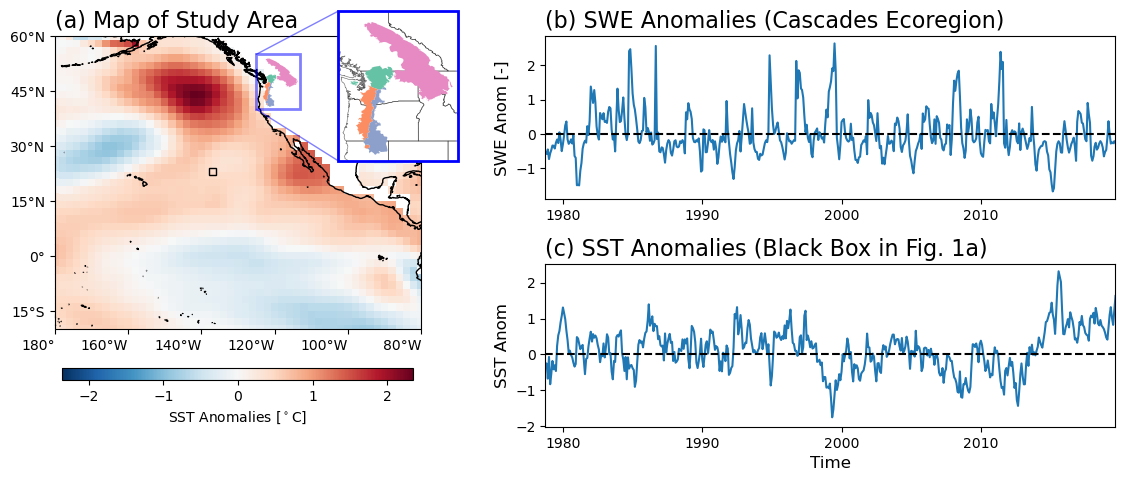

In [38]:
# Figure 1 Code
cascades = xr.open_dataset('./data/snow_by_eco/snow_Cascades.nc')
swe_wc = cascades.swe_level2

pnw_eco = gdf[gdf['NA_L3NAME'].isin(coast_ecos)]
pnw_eco = pnw_eco.to_crs(crs_proj4)
pnw_stations = sntl_pos_gpd.sjoin(pnw_eco, how='inner', predicate='intersects')

# get only Cascades spatial info
gdf_sub = sntl_pos_gpd_w_ecoregions[sntl_pos_gpd_w_ecoregions['NA_L3NAME']=='Cascades']

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(2,3, height_ratios=[0.5,0.5], width_ratios=[1,1,2])
ax = fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())

fig.autofmt_xdate(rotation=0)

ax.coastlines(resolution='50m',
              color='black', linewidth=1)
ax.set_extent([-180, -80, -20, 60], crs=ccrs.PlateCarree())
ax.set_xticks([-180, -160, -140,-120,-100, -80], crs=ccrs.PlateCarree())
ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cbar_kwargs = {'shrink':0.6, 'aspect':30,
               'label':r'SST Anomalies [$^\circ$C]',
               'orientation':'horizontal', 
               'pad':0.1}

ssta.sst.sel(time='2014-03-01').plot(ax=ax,
                                 transform=ccrs.PlateCarree(),
                                 cbar_kwargs=cbar_kwargs)

rect = Rectangle((222,22),2,2, edgecolor='k', facecolor='none', transform=crs)
ax.add_patch(rect)

# inset ax
inset_ax = fig.add_axes([.24, .65, .3, .3], facecolor='w', projection=ccrs.PlateCarree(),
                        xlim=(236, 220), ylim=(40, 55))
inset_ax.add_feature(cfeature.STATES, alpha=0.5,  lw=0.5)
inset_ax.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
inset_ax.spines[:].set_color('b')
inset_ax.spines[:].set_linewidth(2)
ax.indicate_inset_zoom(inset_ax, edgecolor="b", lw=2)

c_Pastel1 = ['#fbb4ae','#b3cde3', '#ccebc5', '#decbe4']
c_Set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
for idx, e in enumerate(coast_ecos):
    pnw_eco[pnw_eco['NA_L3NAME']==e].plot(ax=ax, transform=crs, color=c_Set2[idx])
    pnw_eco[pnw_eco['NA_L3NAME']==e].plot(ax=inset_ax, transform=crs, color=c_Set2[idx], zorder=2)
    
ax.set_title('')
ax.set_title('(a) Map of Study Area', loc='left', fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('')


swe_ax = fig.add_subplot(gs[0,2])
swe_wc.mean(dim='sites').plot(ax=swe_ax)
swe_ax.axhline(y=0, color='k', ls='--')
swe_ax.set_ylabel('SWE Anom [-]', fontsize=12)
swe_ax.set_title('(b) SWE Anomalies (Cascades Ecoregion)', loc='left',fontsize=16)
swe_ax.set_xlabel('')
sst_ax = fig.add_subplot(gs[1,2], sharex=swe_ax)
ssta.sst.sel(lon=222, lat=22).plot(ax=sst_ax)
sst_ax.axhline(y=0, color='k', ls='--')
sst_ax.set_ylabel('SST Anom', fontsize=12)
sst_ax.set_xlabel('Time', fontsize=12)
sst_ax.set_title('')
sst_ax.set_title('(c) SST Anomalies (Black Box in Fig. 1a)', loc='left',fontsize=16)

swe_ax.set_xticks(swe_ax.get_xticks()[:-1],
                          swe_ax.get_xticklabels()[:-1], rotation=0, ha='center')
sst_ax.set_xticks(sst_ax.get_xticks()[:-1],
                          sst_ax.get_xticklabels()[:-1], rotation=0, ha='center')
swe_ax.set_xlim([swe_wc.mean(dim='sites').dropna(dim='time').time[0],swe_wc.time[-1]])

plt.tight_layout()
plt.savefig(pub_dir_main+'fig1a_1c.eps', bbox_inches='tight', facecolor='w', dpi=100)
plt.show()

In [30]:
swes = xr.open_dataset('./data/snotel/swe_musselman_processed.nc').swe_level2
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init


for e in coast_ecos:
    sub = gdf[gdf['NA_L3NAME']==e]
    sub = sub.to_crs(crs_proj4) 
    table = sntl_pos_gpd.sjoin(sub, how='inner', predicate='intersects')
    swe_e = swes.isel(sites=table.index)
    print('{}; {}; {}; {}; {}'.format(e, 
                                      swe_e.shape[0], 
                                      str(pd.to_datetime(swe_e.mean(dim='sites').dropna(dim='time').time[0].values).date()), 
                                      len(swe_e.mean(dim='sites').resample(time='MS').mean().dropna(dim='time')),
                                      [str(np.unique(swe_e.agency)[i]) for i in range(len(np.unique(swe_e.agency)))]
         ))


North Cascades; 32; 1973-10-01; 535; ['BC  ', 'NRCS']
Cascades; 66; 1978-10-01; 492; ['DWR ', 'NRCS']
Eastern Cascades Slopes and Foothills; 25; 1978-10-01; 492; ['DWR ', 'NRCS']
Columbia Mountains/Northern Rockies; 59; 1966-10-01; 636; ['BC  ', 'NRCS']


In [9]:
### consts
path_to_ccm_results = './data/processed/'
ccm_results_flist = np.sort(glob.glob(path_to_ccm_results+'*.nc'))

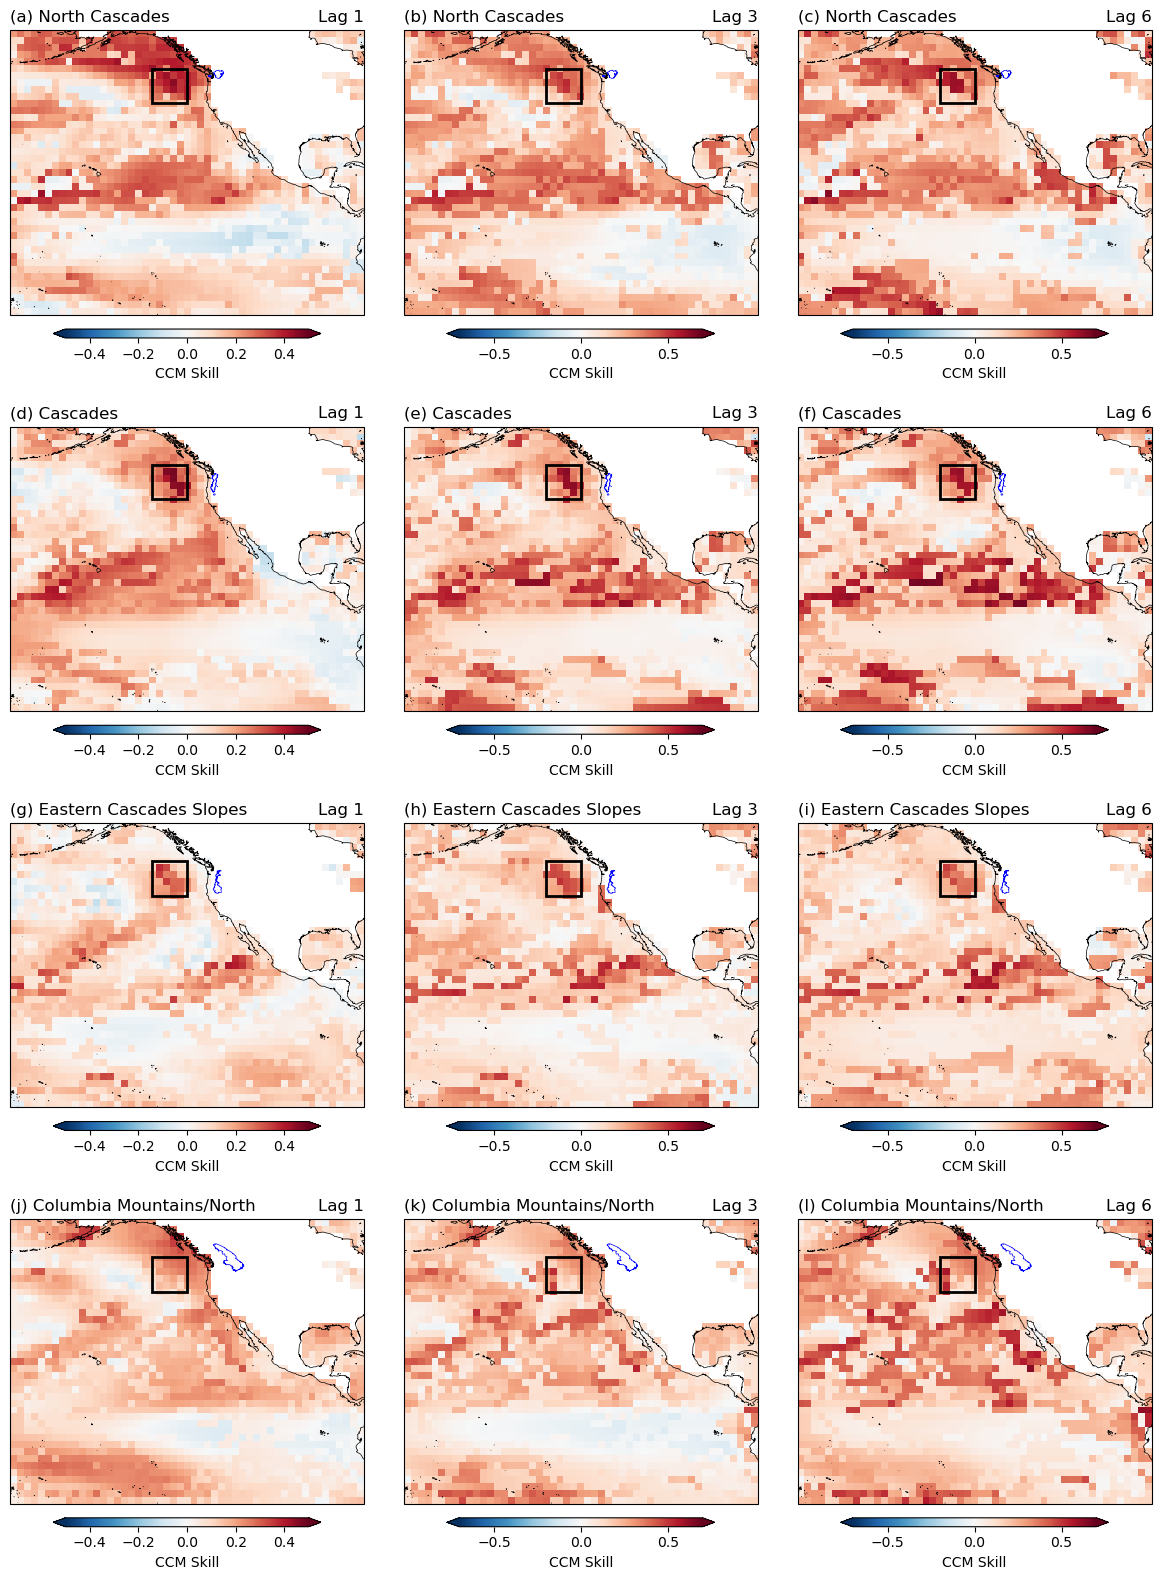

In [44]:
fig = plt.figure(figsize=(12,16))
# create gridspec
gs = fig.add_gridspec(4,3, height_ratios=[1,1,1,1],
                      width_ratios=[1,1,1])

f = ccm_results_flist[3]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

cbar_kwargs = {'shrink':0.7, 'aspect':30,
               'orientation':'horizontal', 'pad':0.04,
               'extend': 'both', 'label': 'CCM Skill'}

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,0],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.5, vmax=0.5,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)
    
    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

f = ccm_results_flist[4]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i+1], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)
    
    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

f = ccm_results_flist[5]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,2],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i+2], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)

    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig(pub_dir_main+'fig2a_2l.eps',
            bbox_inches='tight',
            facecolor='w')
plt.show()

---
# Appendix: High and Low Snow Years
determine the high and low snow years of each ecoregion.

In [11]:
def normSnowYears(ecoregion):
    crs = ccrs.PlateCarree()
    # This can be converted into a `proj4` string/dict compatible with GeoPandas
    crs_proj4 = crs.proj4_init
    
    sub = gdf[gdf['NA_L3NAME']==ecoregion]
    sub_pc = sub.to_crs(crs_proj4)
    sites_in_eco = sntl_pos_gpd.sjoin(sub_pc, how='inner', predicate='intersects')
    swes_in_eco = swes.swe_level2.isel(sites=sites_in_eco.index)

    max_yearly_swe = swes_in_eco.mean(dim='sites').groupby('time.year').max()
    max_yearly_swe_df = max_yearly_swe.to_dataframe()

    max_yearly_swe_mean = max_yearly_swe_df.mean().values[0]
    max_yearly_swe_std = max_yearly_swe_df.std().values[0]

    max_yearly_swe_z = (max_yearly_swe_df - max_yearly_swe_mean)/(max_yearly_swe_std)
    max_yearly_swe_z = max_yearly_swe_z.dropna()
    first_year = max_yearly_swe_z.index[0]
    max_yearly_swe_z = max_yearly_swe_z.drop(index=first_year, axis=0)
    return(max_yearly_swe_z)

def getHighLowYears(z, ul=1, ll=-1):
    high = z[z['swe_level2']>ul].sort_values(by='swe_level2', ascending=False)
    low = z[z['swe_level2']<-ll].sort_values(by='swe_level2', ascending=True)
    return(high, low)

In [12]:
swes = xr.open_dataset('./data/snotel/swe_musselman_processed.nc')

In [13]:
Ca_normed = normSnowYears('Cascades')
Ca_h, Ca_l = getHighLowYears(Ca_normed)

Text(0.5, 1.0, 'Cascades Maximum SWE')

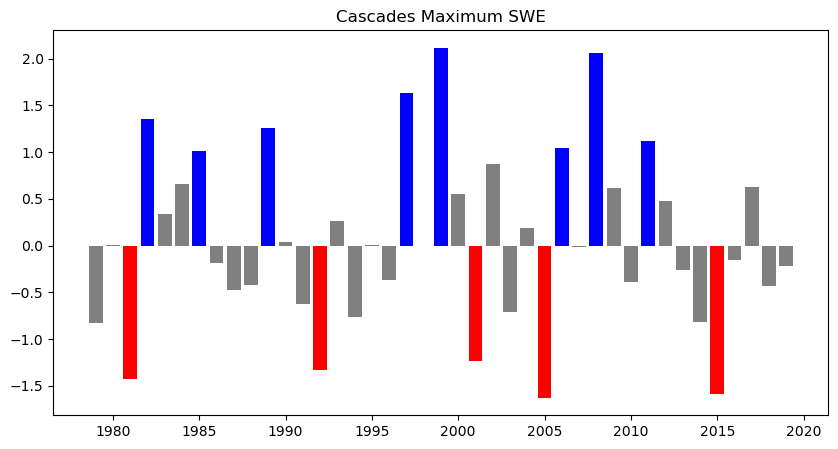

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
# max_yearly_swe_df[max_yearly_swe_df['swe_level2']>600].plot.bar(ax=ax, width=0.9, color='b')
profit_color = [{s<-1: 'red', -1<=s<=1: 'grey', s>1: 'blue'}[True] for s in Ca_normed['swe_level2'].dropna()]
# max_yearly_swe_df.plot.bar(ax=ax, width=0.9, color=profit_color)
ax.bar(x=Ca_normed.dropna().index,
       height=Ca_normed['swe_level2'].dropna(), color=profit_color)
ax.set_title('Cascades Maximum SWE')

In [15]:
NC_normed = normSnowYears('North Cascades')
NC_h, NC_l = getHighLowYears(NC_normed, ul=0.7)

Text(0.5, 1.0, 'North Cascades Maximum SWE')

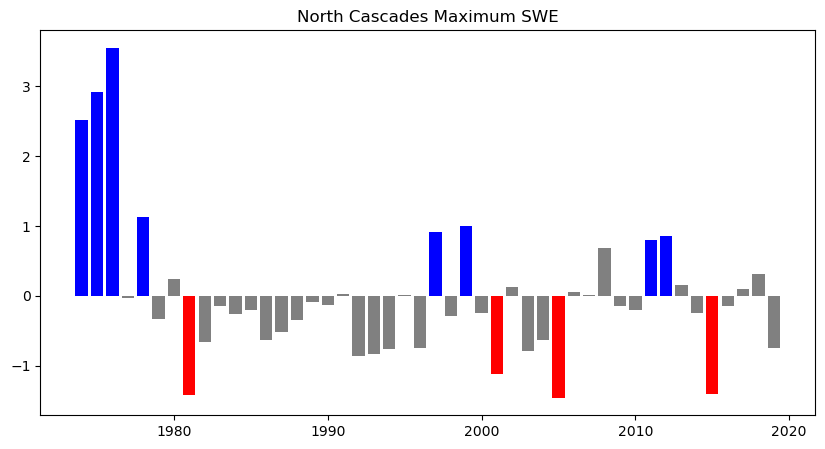

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
# max_yearly_swe_df[max_yearly_swe_df['swe_level2']>600].plot.bar(ax=ax, width=0.9, color='b')
profit_color = [{s<-1: 'red', -1<=s<=0.7: 'grey', s>0.7: 'blue'}[True] for s in NC_normed['swe_level2'].dropna()]
# max_yearly_swe_df.plot.bar(ax=ax, width=0.9, color=profit_color)
ax.bar(x=NC_normed.dropna().index,
       height=NC_normed['swe_level2'].dropna(), color=profit_color)
ax.set_title('North Cascades Maximum SWE')

In [17]:
CM_normed = normSnowYears('Columbia Mountains/Northern Rockies')
CM_h, CM_l = getHighLowYears(CM_normed)

Text(0.5, 1.0, 'Columbia Mountains Maximum SWE')

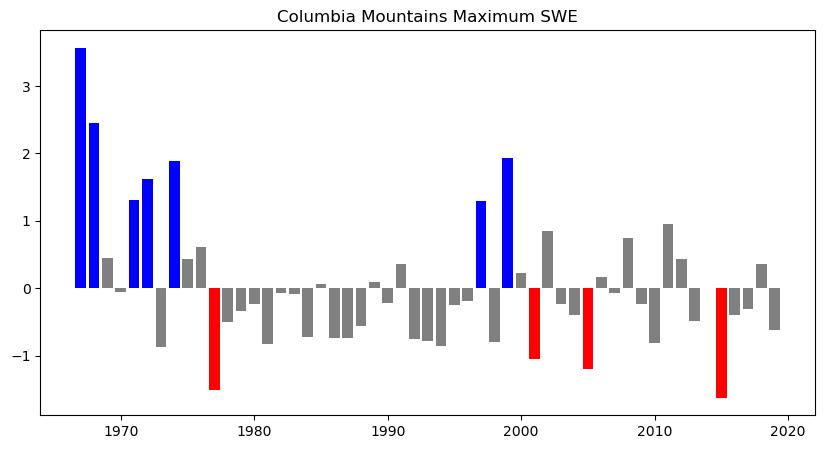

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
# max_yearly_swe_df[max_yearly_swe_df['swe_level2']>600].plot.bar(ax=ax, width=0.9, color='b')
profit_color = [{s<-1: 'red', -1<=s<=1: 'grey', s>1: 'blue'}[True] for s in CM_normed['swe_level2'].dropna()]
# max_yearly_swe_df.plot.bar(ax=ax, width=0.9, color=profit_color)
ax.bar(x=CM_normed.dropna().index,
       height=CM_normed['swe_level2'].dropna(), color=profit_color)
ax.set_title('Columbia Mountains Maximum SWE')

---
# SI Plots

In [19]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree(central_longitude=180)

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)
sntl_pos_gpd = sntl_pos_gpd.to_crs(crs_proj4)

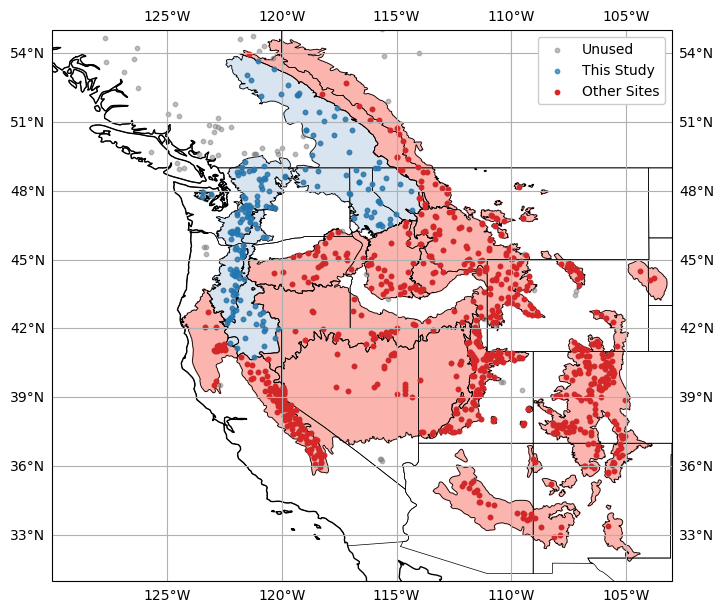

In [46]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={
    "projection": ccrs.PlateCarree()})
ax.coastlines(resolution='50m',
              color='black', linewidth=1)
ax.set_extent([-130, -103, 31, 55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, linewidth=0.5)

wus_eco = gdf[gdf['NA_L3NAME'].isin(eco_regions)]
wus_eco = wus_eco.to_crs(ccrs.PlateCarree())
wus_eco.boundary.plot(ax=ax, color='k', lw=0.6)

pnw_sites = gdf[gdf['NA_L3NAME'].isin(coast_ecos)]
pnw_sites = pnw_sites.to_crs(ccrs.PlateCarree())
eco_sites = gdf[gdf['NA_L3NAME'].isin(ecos_not_in)]
eco_sites = eco_sites.to_crs(ccrs.PlateCarree())
pnw_sites.to_crs(crs_proj4)
eco_sites.to_crs(crs_proj4)


ax.add_geometries(pnw_sites['geometry'], crs=ccrs.PlateCarree(),
                  color=c_Pastel1[1], alpha=0.5, zorder=1)
ax.add_geometries(eco_sites['geometry'], crs=ccrs.PlateCarree(),
                  color=c_Pastel1[0], zorder=1)

sntl_pos_gpd.plot(ax=ax, zorder=2, color='grey',
                  alpha=0.5, label='Unused', markersize=10)

pnw_xy = sntl_pos_gpd.sjoin(pnw_sites, how='inner', predicate='intersects')
pnw_xy.plot(ax=ax, zorder=3, label='This Study', alpha=0.7, markersize=10)


eco_xy = sntl_pos_gpd.sjoin(eco_sites, how='inner', predicate='intersects')
eco_xy.plot(ax=ax, zorder=2, color='tab:red', label='Other Sites', markersize=10)


gl = ax.gridlines(draw_labels=True)
ax.legend(framealpha=1)
plt.savefig(pub_dir_supp+'fig_s1.png', bbox_inches='tight', facecolor='w')
plt.show()

In [31]:
swes = swes.swe_level2
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()
# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init


for e in ecos_not_in:
    sub = gdf[gdf['NA_L3NAME']==e]
    sub = sub.to_crs(crs_proj4) 
    table = sntl_pos_gpd.sjoin(sub, how='inner', predicate='intersects')
    swe_e = swes.isel(sites=table.index)
    print('{}; {}; {}; {}; {}'.format(e, 
                                      swe_e.shape[0], 
                                      str(pd.to_datetime(swe_e.mean(dim='sites').dropna(dim='time').time[0].values).date()), 
                                      len(swe_e.mean(dim='sites').resample(time='MS').mean().dropna(dim='time')),
                                      [str(np.unique(swe_e.agency)[i]) for i in range(len(np.unique(swe_e.agency)))]
         ))


Middle Rockies; 140; 1963-10-01; 672; ['NRCS']
Klamath Mountains; 15; 1980-10-01; 468; ['DWR ', 'NRCS']
Sierra Nevada; 116; 1965-10-01; 648; ['DWR ', 'NRCS']
Wasatch and Uinta Mountains; 115; 1966-10-01; 564; ['NRCS']
Southern Rockies; 159; 1966-10-01; 636; ['NRCS']
Idaho Batholith; 38; 1967-10-01; 624; ['NRCS']
Canadian Rockies; 32; 1968-10-01; 612; ['AB  ', 'BC  ', 'NRCS']
Blue Mountains; 30; 1978-10-01; 492; ['NRCS']
Central Basin and Range; 33; 1978-10-01; 492; ['NRCS']
Arizona/New Mexico Mountains; 31; 1978-10-01; 492; ['NRCS']
Northern Basin and Range; 31; 1978-10-01; 492; ['NRCS']


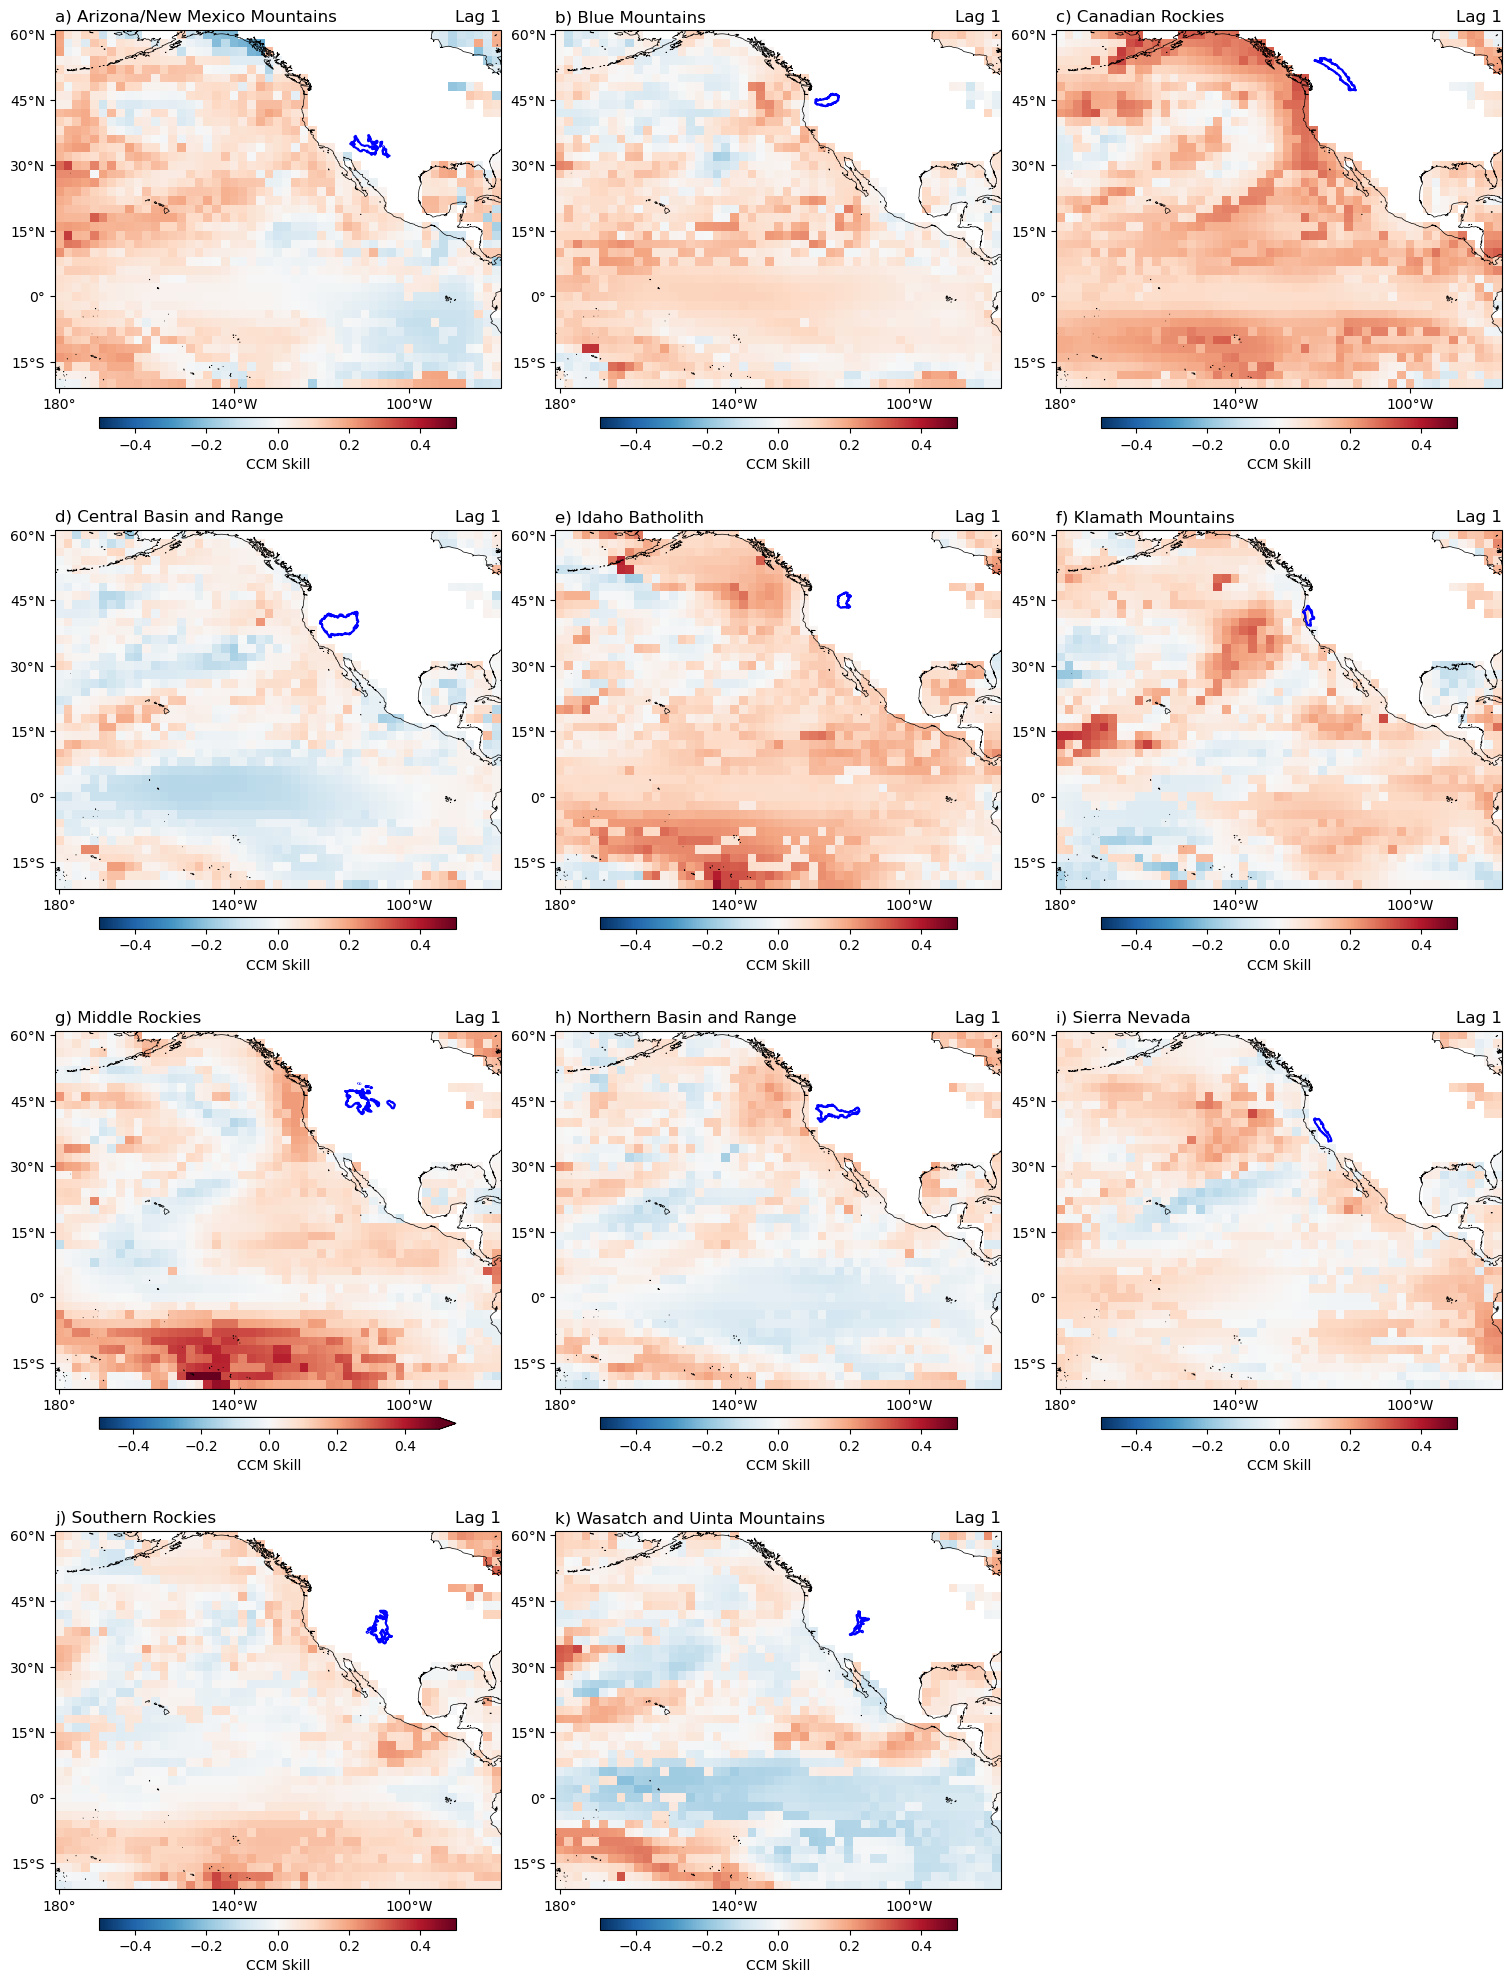

In [25]:
# def plot_ccm(f):
f = ccm_results_flist[3]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(15, 20), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(4,3, height_ratios=[1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':30,
               'orientation':'horizontal', 'pad':0.01,
               'label': 'CCM Skill'}

for i, e in enumerate(sorted(ecos_not_in)):
    sub = wus_eco[wus_eco['NA_L3NAME']==e]
    sub = sub.to_crs(ccrs.PlateCarree(central_longitude=180))
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=e).rho.plot(ax=ax,                                       
                                       cmap='RdBu_r',
                                       vmin=-0.5, vmax=0.5,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], e), loc='left')
    ax.set_title(f'Lag {lag}', loc='right')
    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig(pub_dir_supp+'fig_s2a-s2k.png', bbox_inches='tight', facecolor='w')
plt.show()

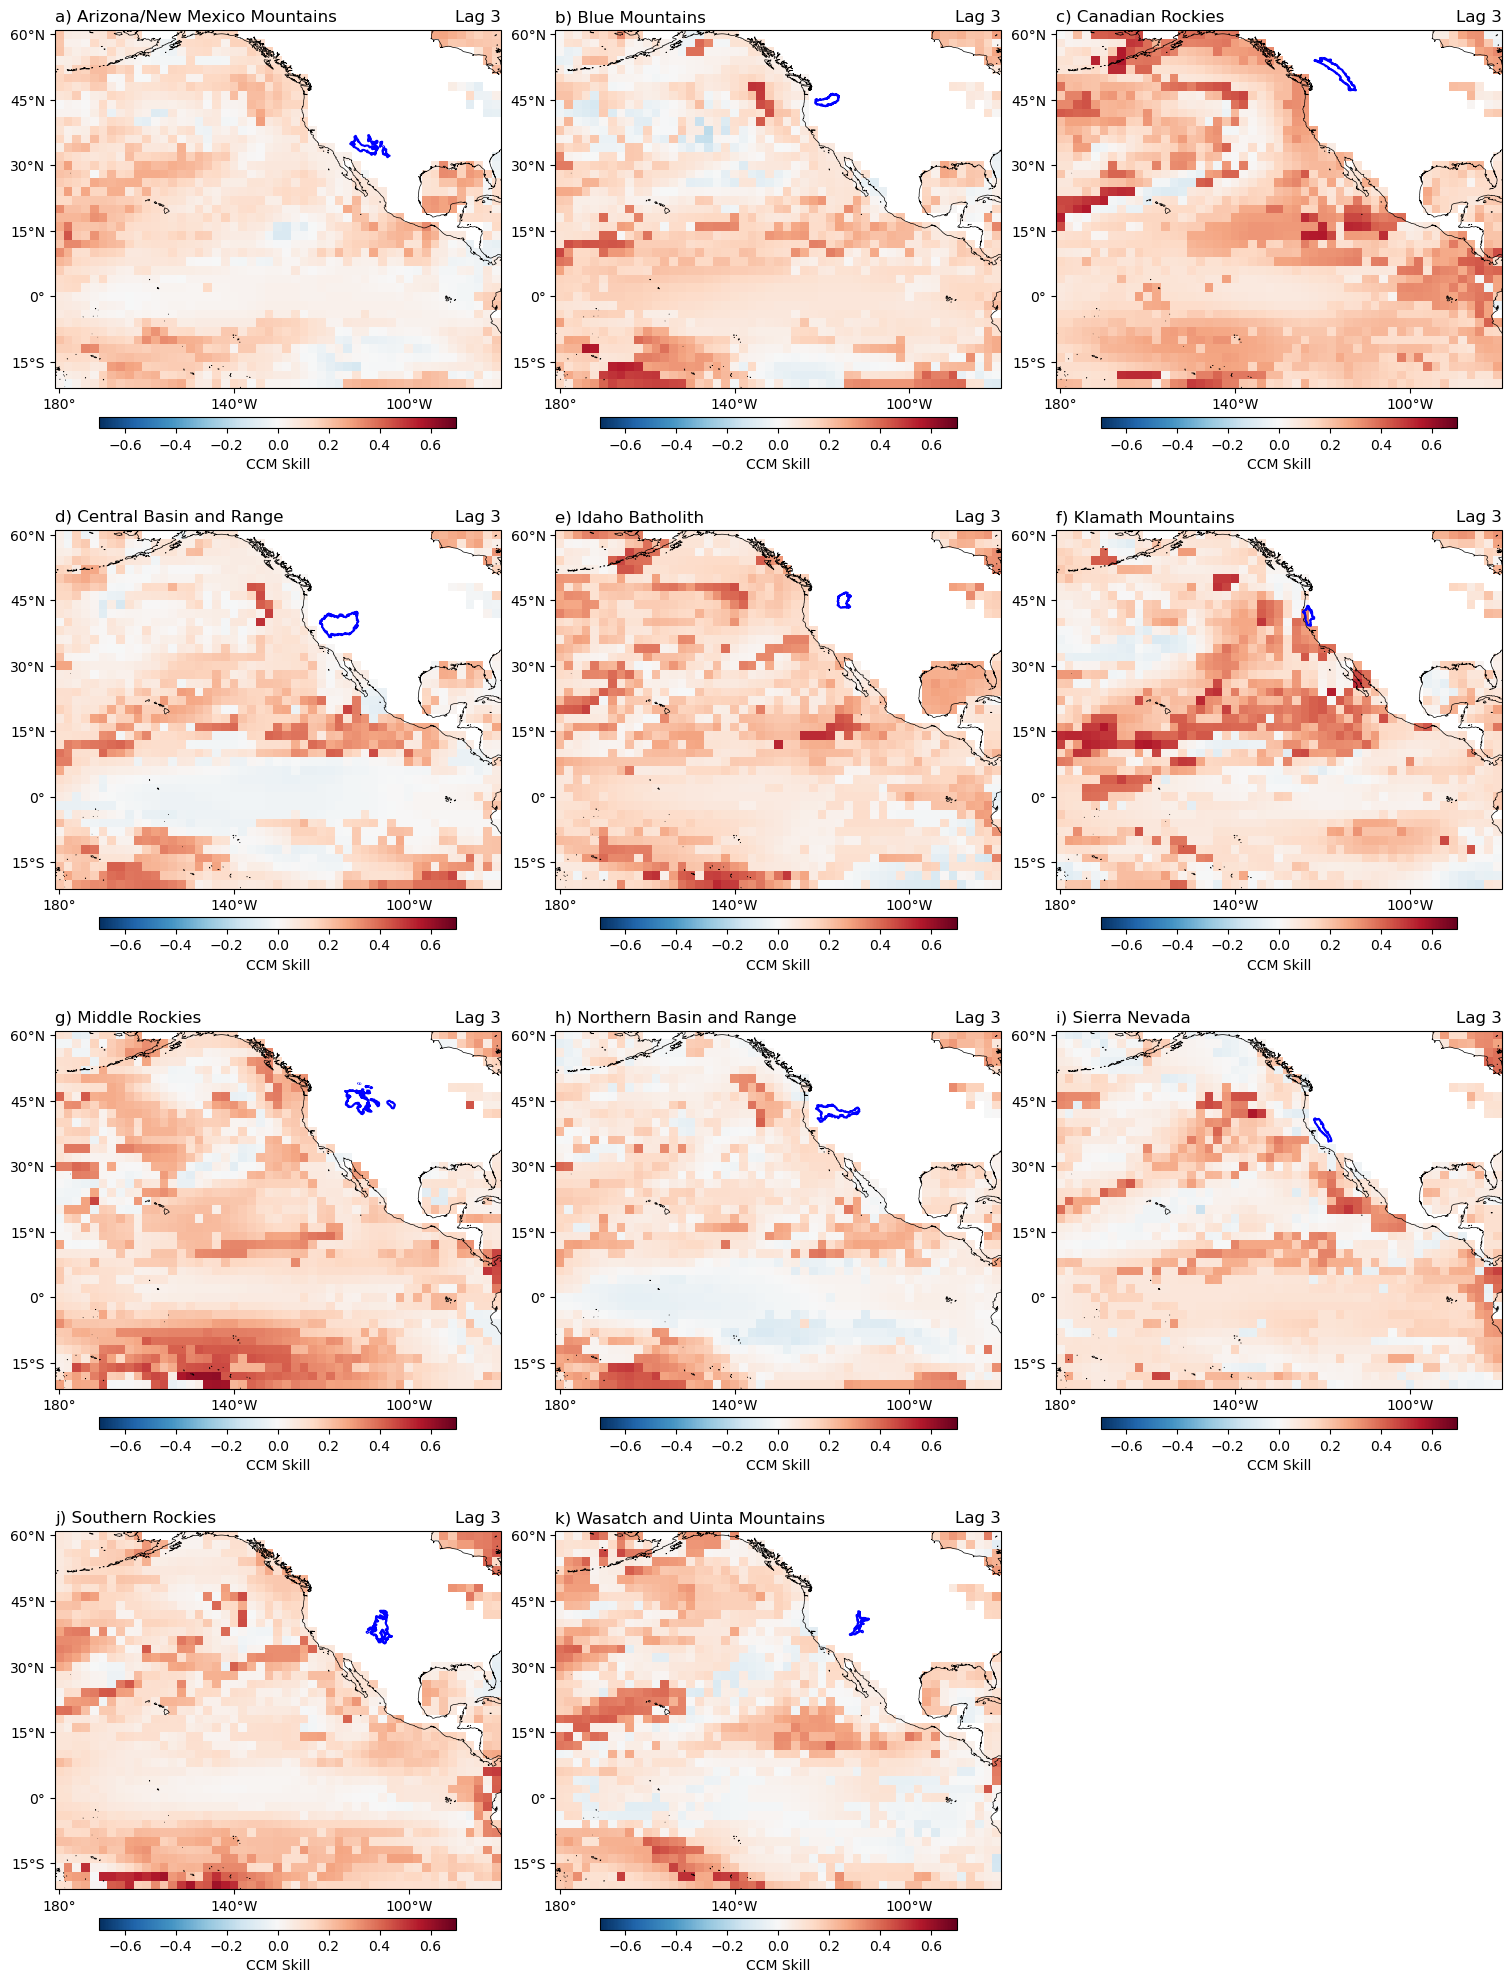

In [26]:
# def plot_ccm(f):
f = ccm_results_flist[4]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(15, 20), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(4,3, height_ratios=[1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':30,
               'orientation':'horizontal', 'pad':0.01,
               'label': 'CCM Skill'}

for i, e in enumerate(sorted(ecos_not_in)):
    sub = wus_eco[wus_eco['NA_L3NAME']==e]
    sub = sub.to_crs(ccrs.PlateCarree(central_longitude=180))
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=e).rho.plot(ax=ax,                                       
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], e), loc='left')
    ax.set_title(f'Lag {lag}', loc='right')
    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig(pub_dir_supp+'fig_s3a-s3k.png', bbox_inches='tight', facecolor='w')
plt.show()

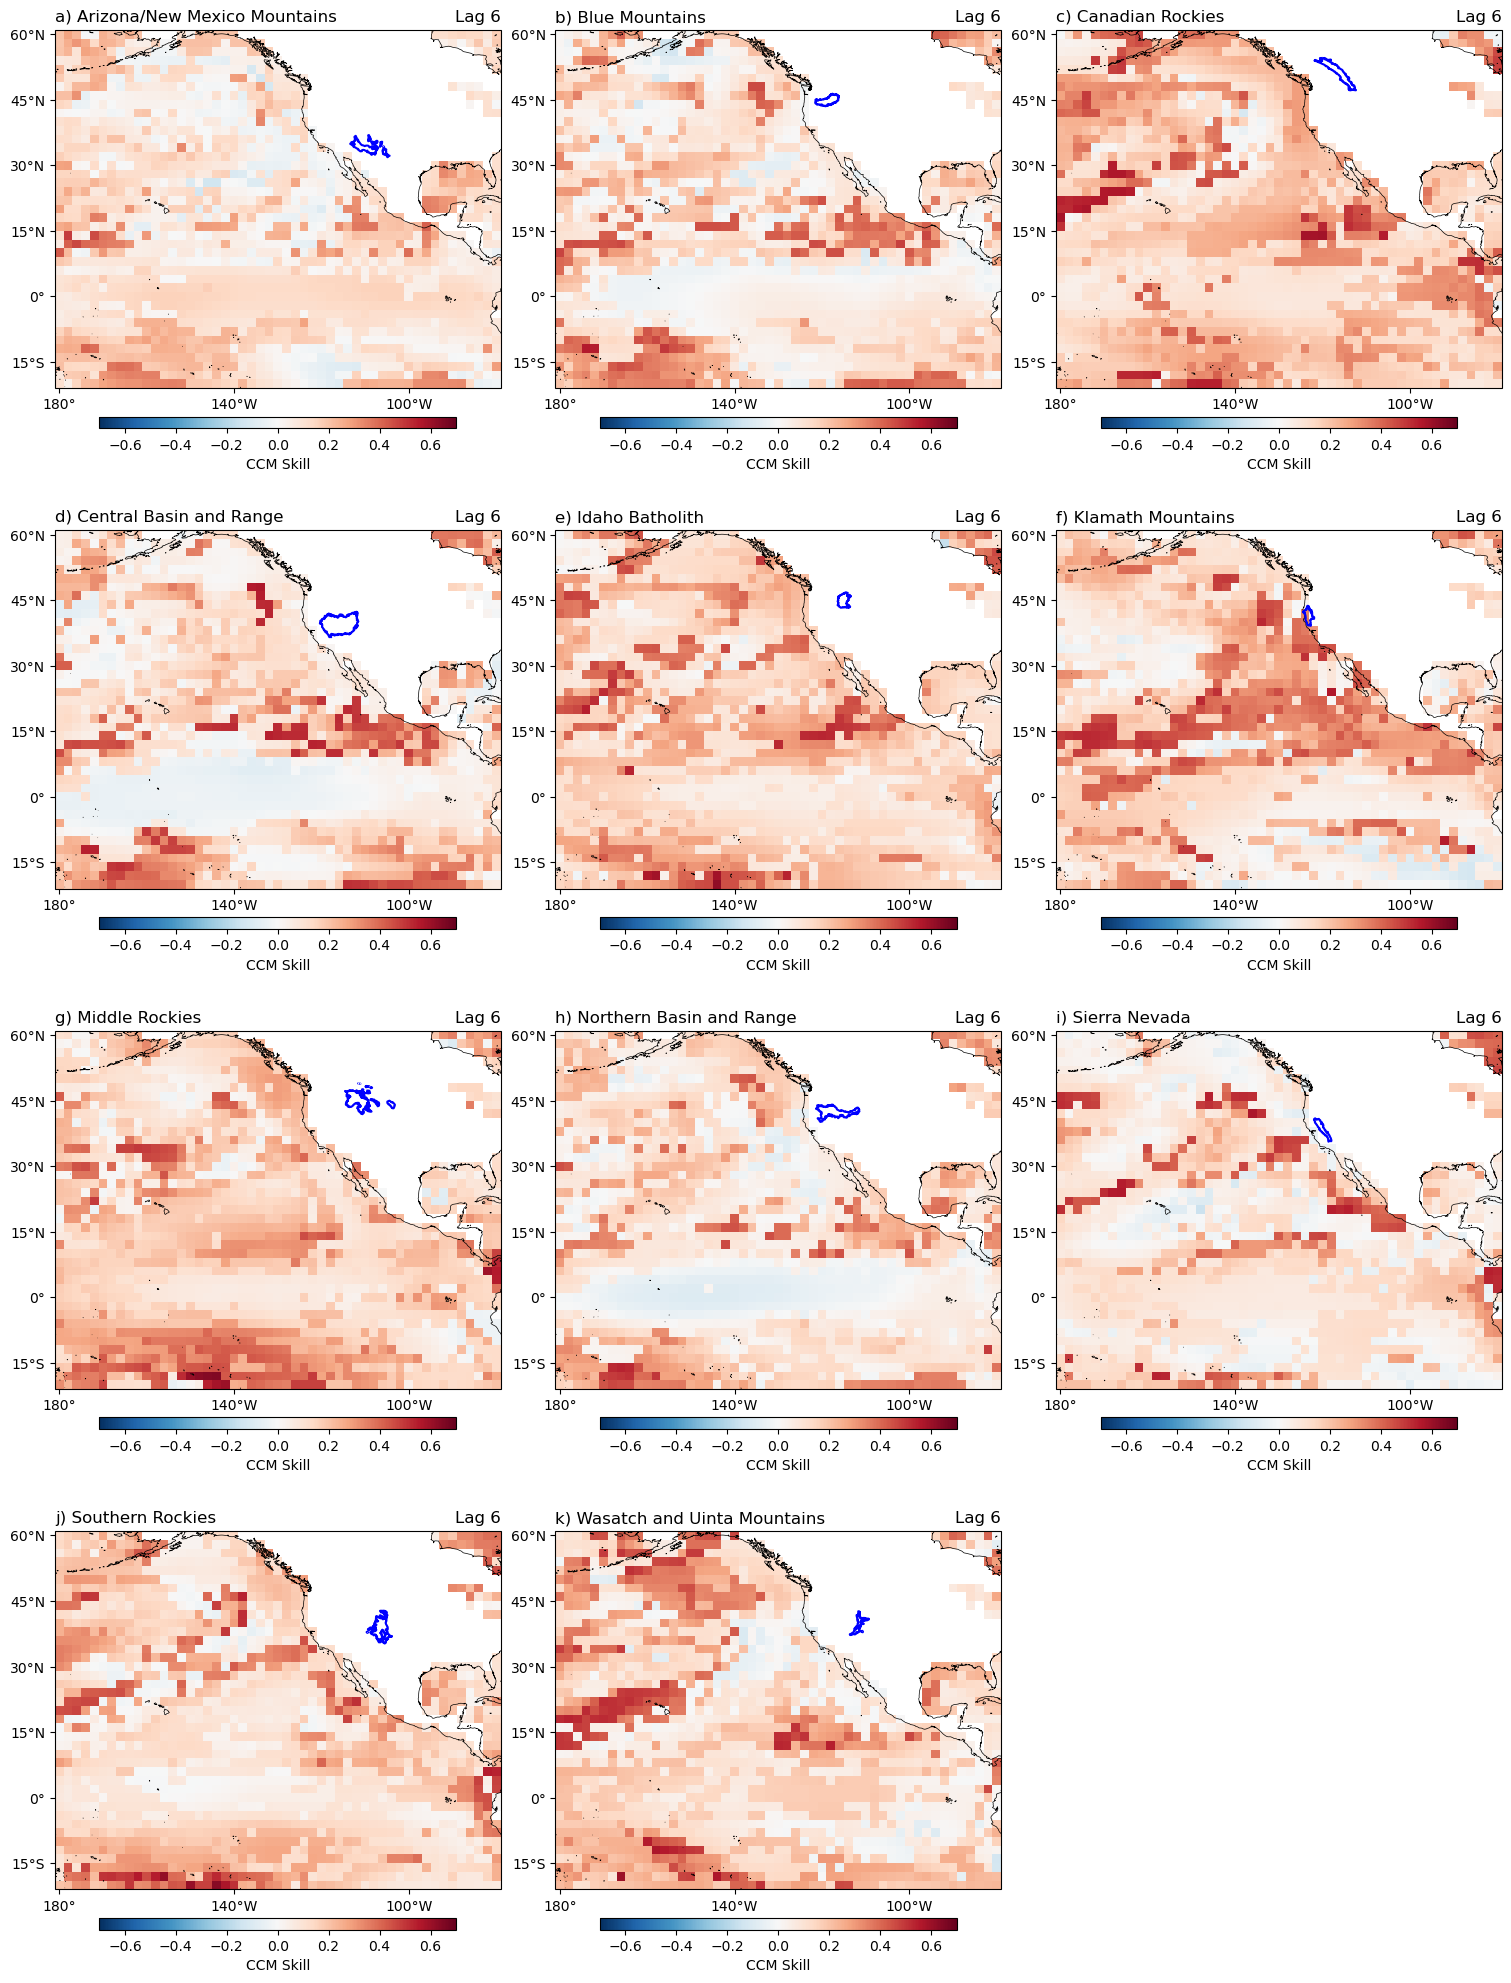

In [27]:
# def plot_ccm(f):
f = ccm_results_flist[5]

lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)
fig = plt.figure(figsize=(15, 20), constrained_layout=True)
# create gridspec
gs = fig.add_gridspec(4,3, height_ratios=[1,1,1,1],
                      width_ratios=[1,1,1])

cbar_kwargs = {'shrink':0.8, 'aspect':30,
               'orientation':'horizontal', 'pad':0.01,
               'label': 'CCM Skill'}

for i, e in enumerate(sorted(ecos_not_in)):
    sub = wus_eco[wus_eco['NA_L3NAME']==e]
    sub = sub.to_crs(ccrs.PlateCarree(central_longitude=180))
    ax = fig.add_subplot(gs[i],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=e).rho.plot(ax=ax,                                       
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b')
    ax.set_title('')
    ax.set_title('{}) {}'.format(alc[i], e), loc='left')
    ax.set_title(f'Lag {lag}', loc='right')
    ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig(pub_dir_supp+'fig_s4a-s4k.png', bbox_inches='tight', facecolor='w')
plt.show()